## Import Library

In [ ]:
Muhammad Zhafran Ghaly

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, GridSearchCV
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from flask import Flask, request, jsonify
from surprise.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer


In [157]:
# Load dataset
ratings_small = pd.read_csv('/content/drive/MyDrive/Project/Movie/ratings_small.csv')
tmdb_5000_credits = pd.read_csv('/content/drive/MyDrive/Project/Movie/tmdb_5000_credits.csv')
tmdb_5000_movies = pd.read_csv('/content/drive/MyDrive/Project/Movie/tmdb_5000_movies.csv')

tmdb_5000_credits.columns = ['id', 'title', 'cast', 'crew']
tmdb_5000_movies= tmdb_5000_movies.merge(tmdb_5000_credits,on='id')

tmdb_5000_movies = tmdb_5000_movies.rename(columns={'original_title': 'title'})
# Tampilkan 5 baris pertama
tmdb_5000_movies.head(5)

,budget,genres,homepage,id,keywords,original_language,title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [230]:
# Periksa beberapa baris pertama dari kolom yang diharapkan
tmdb_5000_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 4803 non-null   int64         
 1   budget                4803 non-null   int64         
 2   genres                4803 non-null   object        
 3   homepage              1712 non-null   object        
 4   id                    4803 non-null   int64         
 5   keywords              4803 non-null   object        
 6   original_language     4803 non-null   object        
 7   title                 4803 non-null   object        
 8   overview              4803 non-null   object        
 9   popularity            4803 non-null   float64       
 10  production_companies  4803 non-null   object        
 11  production_countries  4803 non-null   object        
 12  release_date          4802 non-null   datetime64[ns]
 13  revenue           

In [231]:
tmdb_5000_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4803 non-null   int64 
 1   title   4803 non-null   object
 2   cast    4803 non-null   object
 3   crew    4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [159]:
C= tmdb_5000_movies['vote_average'].mean()
C

m= tmdb_5000_movies['vote_count'].quantile(0.9)
m

q_movies = tmdb_5000_movies.copy().loc[tmdb_5000_movies['vote_count'] >= m]
q_movies.shape

(481, 23)

In [160]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [161]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


,overview
0,"In the 22nd century, a paraplegic Marine is di..."
1,"Captain Barbossa, long believed to be dead, ha..."
2,A cryptic message from Bond’s past sends him o...
3,Following the death of District Attorney Harve...
4,"John Carter is a war-weary, former military ca..."


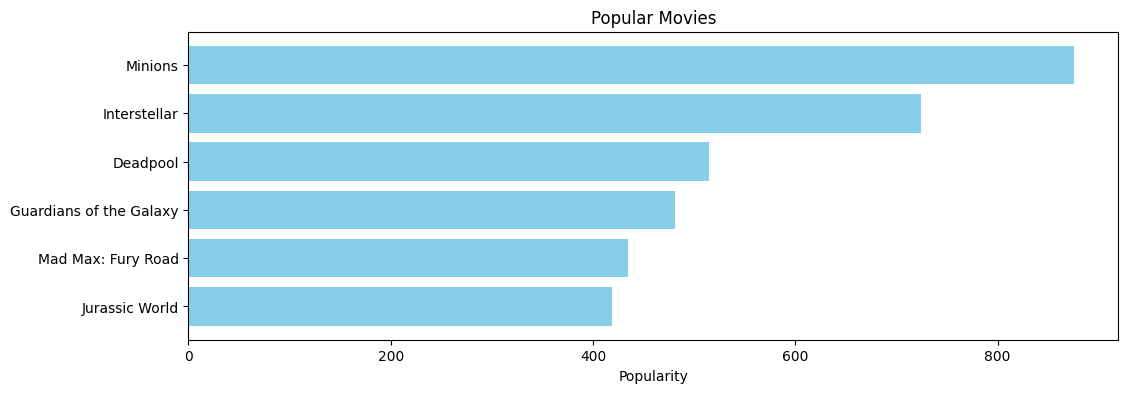

In [162]:
pop= tmdb_5000_movies.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

tmdb_5000_movies['overview'].head(5)

In [163]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all English stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
tmdb_5000_movies['overview'] = tmdb_5000_movies['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(tmdb_5000_movies['overview'])

#Output the shape of tfidf_matrix
print(tfidf_matrix.shape)

(4803, 20978)


In [164]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse map of indices and movie titles
indices = pd.Series(tmdb_5000_movies.index, index=tmdb_5000_movies['title']).drop_duplicates()

# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return tmdb_5000_movies['title'].iloc[movie_indices]

In [165]:
get_recommendations('The Dark Knight Rises')

,title
65,The Dark Knight
299,Batman Forever
428,Batman Returns
1359,Batman
3854,"Batman: The Dark Knight Returns, Part 2"
119,Batman Begins
2507,Slow Burn
9,Batman v Superman: Dawn of Justice
1181,JFK
210,Batman & Robin


In [166]:
get_recommendations('The Avengers')

,title
7,Avengers: Age of Ultron
3144,Plastic
1715,Timecop
4124,This Thing of Ours
3311,Thank You for Smoking
3033,The Corruptor
588,Wall Street: Money Never Sleeps
2136,Team America: World Police
1468,The Fountain
1286,Snowpiercer


In [195]:
# Define the reader
reader = Reader()

data = Dataset.load_from_df(ratings_small[['userId', 'movieId', 'rating']], reader)

# Definisikan parameter grid
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}


In [196]:
# Lakukan Grid Search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# Cetak hasil terbaik
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# Membagi data menjadi trainset dan testset
trainset, testset = train_test_split(data, test_size=0.25)

0.891477307669755
{'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


In [197]:
# Gunakan model terbaik
algo = gs.best_estimator['rmse']
algo.fit(trainset)

ratings_small[ratings_small['userId'] == 1]

algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.694725960069291, details={'was_impossible': False})

In [214]:
tmdb_5000_movies['overview_tokens'] = tmdb_5000_movies['overview'].apply(lambda x: x.split())

# Latih model Word2Vec
model = Word2Vec(sentences=tmdb_5000_movies['overview_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Mendapatkan vektor untuk setiap overview
def get_vector(tokens):
    # Filter out tokens not in the model's vocabulary
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        # Return a zero vector if no valid tokens are found
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in valid_tokens], axis=0)

tmdb_5000_movies['overview_vector'] = tmdb_5000_movies['overview_tokens'].apply(get_vector)

# Hitung cosine similarity berdasarkan vektor Word2Vec
overview_vectors = np.array(tmdb_5000_movies['overview_vector'].tolist())
cosine_sim_w2v = cosine_similarity(overview_vectors, overview_vectors)

In [215]:
# Fungsi rekomendasi menggunakan Word2Vec
def get_recommendations_w2v(title, cosine_sim=cosine_sim_w2v):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return tmdb_5000_movies['title'].iloc[movie_indices]

In [216]:
# Contoh penggunaan
get_recommendations_w2v('The Dark Knight Rises')

,title
2921,Drive Hard
375,Bicentennial Man
4018,Sur le seuil
4758,The Signal
2708,Caravans
848,The Pirates! In an Adventure with Scientists!
2227,Battle of the Year
1890,Don Juan DeMarco
1765,The Newton Boys
1490,Return of the Jedi


In [217]:
# Sort movies by popularity
popular_movies = tmdb_5000_movies.sort_values('popularity', ascending=False)

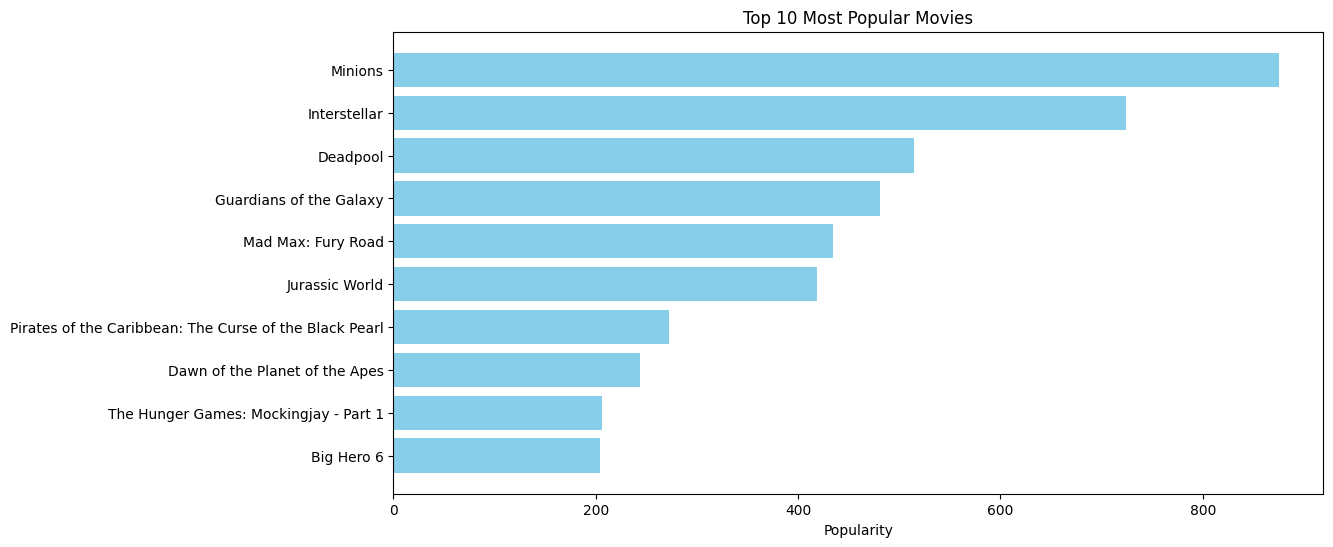

In [218]:
# Plot top 10 popular movies
plt.figure(figsize=(12, 6))
plt.barh(popular_movies['title'].head(10), popular_movies['popularity'].head(10), color='skyblue')
plt.xlabel('Popularity')
plt.title('Top 10 Most Popular Movies')
plt.gca().invert_yaxis()
plt.show()



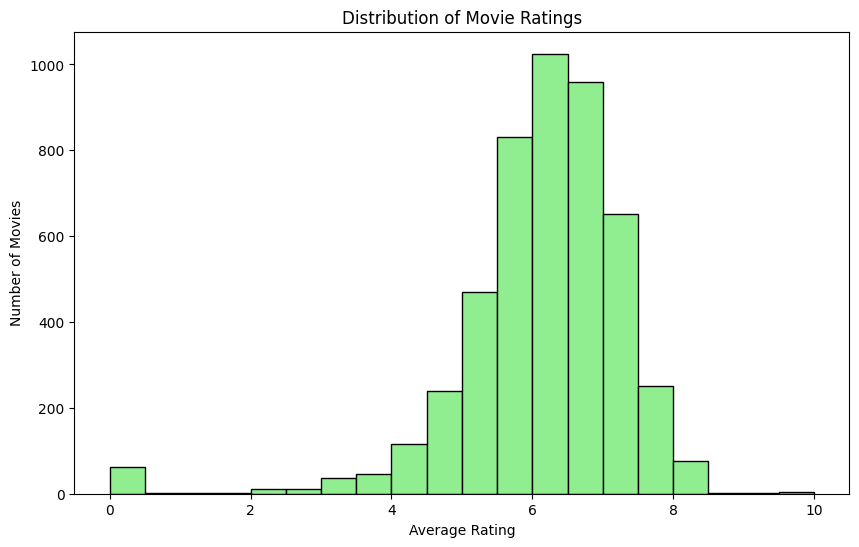

In [219]:
plt.figure(figsize=(10, 6))
plt.hist(tmdb_5000_movies['vote_average'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Ratings')
plt.show()

In [220]:
# Generate word cloud for recommended movies
recommended_movies = get_recommendations('The Dark Knight Rises')
text = ' '.join(tmdb_5000_movies[tmdb_5000_movies['title'].isin(recommended_movies)]['overview'].fillna(''))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)


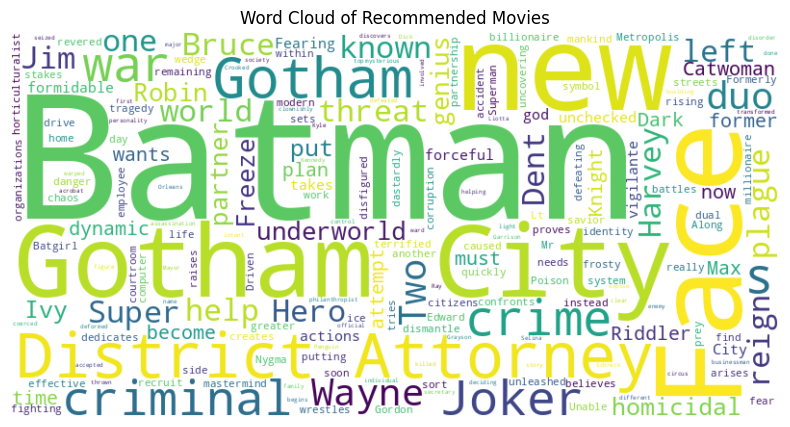

In [221]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Recommended Movies')
plt.show()

In [222]:
# Bagian 4: Trend Rating dari Waktu ke Waktu
# Assuming 'release_date' is available and in datetime format
tmdb_5000_movies['release_date'] = pd.to_datetime(tmdb_5000_movies['release_date'])
tmdb_5000_movies['year'] = tmdb_5000_movies['release_date'].dt.year

In [223]:
average_rating_per_year = tmdb_5000_movies.groupby('year')['vote_average'].mean()


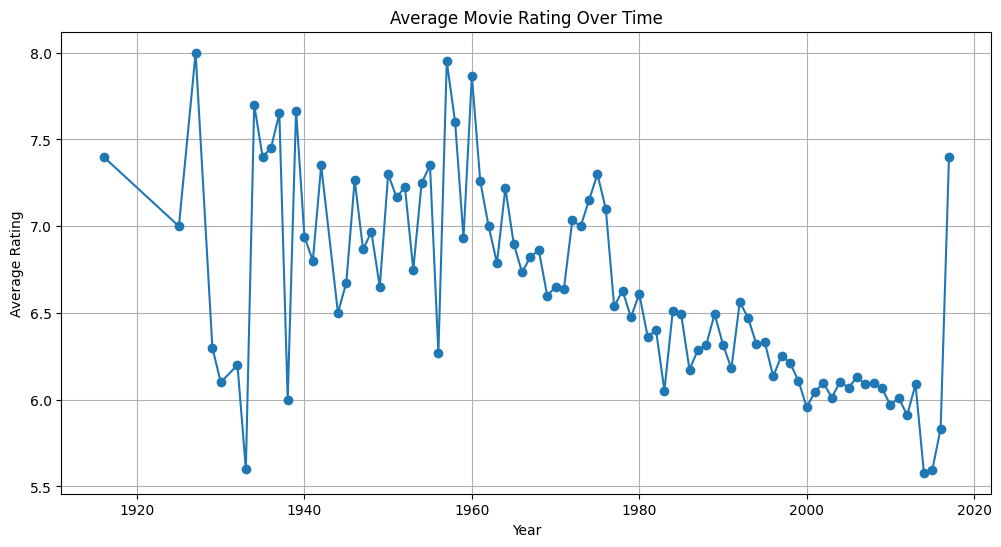

In [211]:
plt.figure(figsize=(12, 6))
plt.plot(average_rating_per_year.index, average_rating_per_year.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Rating Over Time')
plt.grid(True)
plt.show()

In [224]:
# Cetak hasil terbaik dari GridSearchCV
print("Best RMSE score from GridSearchCV:", gs.best_score['rmse'])

# Gunakan model terbaik untuk prediksi pada testset
predictions = algo.test(testset)

# Hitung RMSE pada testset
from surprise import accuracy
rmse = accuracy.rmse(predictions)
print("RMSE on testset:", rmse)

Best RMSE score from GridSearchCV: 0.891477307669755
RMSE: 0.8868
RMSE on testset: 0.8868258963791363


In [ ]:
app = Flask(__name__)

@app.route('/recommend', methods=['GET'])
def recommend():
    title = request.args.get('title')
    recommendations = get_recommendations_w2v(title)
    return jsonify(recommendations.tolist())

if __name__ == '__main__':
    app.run(debug=True)
